In [5]:
from birdclef.spark import get_spark
from pyspark.sql import functions as F
import librosa
from pathlib import Path

spark = get_spark(cores=8, driver_memory="20g")
spark

25/03/23 13:13:53 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [15]:
root = Path("~/shared/birdclef/raw/birdclef-2025").expanduser().resolve()
! tree {root} -L 1

/storage/coda1/p-dsgt_clef2025/0/shared/birdclef/raw/birdclef-2025
├── recording_location.txt
├── sample_submission.csv
├── taxonomy.csv
├── test_soundscapes
├── train_audio
├── train.csv
└── train_soundscapes

3 directories, 4 files


In [20]:
train = spark.read.csv(f"{root}/train.csv", header=True)
train.printSchema()
train.show(1, vertical=True, truncate=100)

root
 |-- primary_label: string (nullable = true)
 |-- secondary_labels: string (nullable = true)
 |-- type: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- collection: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- url: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- scientific_name: string (nullable = true)
 |-- common_name: string (nullable = true)
 |-- author: string (nullable = true)
 |-- license: string (nullable = true)

-RECORD 0--------------------------------------------------------------------------------------------
 primary_label    | 1139490                                                                          
 secondary_labels | ['']                                                                             
 type             | ['']                                                                             
 filename         | 1139490/CSA36385.ogg              

In [25]:
train.count()

28564

In [21]:
taxonomy = spark.read.csv(f"{root}/taxonomy.csv", header=True)
taxonomy.printSchema()
taxonomy.show(1, vertical=True, truncate=100)

root
 |-- primary_label: string (nullable = true)
 |-- inat_taxon_id: string (nullable = true)
 |-- scientific_name: string (nullable = true)
 |-- common_name: string (nullable = true)
 |-- class_name: string (nullable = true)

-RECORD 0-------------------------------
 primary_label   | 1139490              
 inat_taxon_id   | 1139490              
 scientific_name | Ragoniella pulchella 
 common_name     | Ragoniella pulchella 
 class_name      | Insecta              
only showing top 1 row



In [23]:
! cat {root}/recording_location.txt

Nature reserve "El Silencio" in the municipality of Yondó in the Middle Magdalena Valley of Colombia.

Website: https://www.fundacionbiodiversa.org/fundacion2024/information/  

Coordinates:

Latitude: 6.76
Longitude: -74.21

In [ ]:
# let's count how long each recording is


@F.udf("double")
def duration(path):
    return librosa.get_duration(filename=path)


duration = (
    train.select("primary_label", "filename")
    .withColumn("path", F.concat(F.lit(str(root)), F.lit("/train_audio/"), "filename"))
    .withColumn("duration", duration("path"))
)

duration.show(10)

# NOTE: we'll actually implement this as a script since it's going to take a while to run

/tmp/ipykernel_3854868/3729165388.py:5: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.


+-------------+--------------------+--------------------+------------+
|primary_label|            filename|                path|    duration|
+-------------+--------------------+--------------------+------------+
|      1139490|1139490/CSA36385.ogg|/storage/coda1/p-...|   98.853375|
|      1139490|1139490/CSA36389.ogg|/storage/coda1/p-...| 96.53771875|
|      1192948|1192948/CSA36358.ogg|/storage/coda1/p-...| 116.5998125|
|      1192948|1192948/CSA36366.ogg|/storage/coda1/p-...| 105.4463125|
|      1192948|1192948/CSA36373.ogg|/storage/coda1/p-...|103.63146875|
|      1192948|1192948/CSA36388.ogg|/storage/coda1/p-...| 96.07284375|
|      1194042|1194042/CSA18783.ogg|/storage/coda1/p-...|  32.2718125|
|      1194042|1194042/CSA18794.ogg|/storage/coda1/p-...|   13.493625|
|      1194042|1194042/CSA18802.ogg|/storage/coda1/p-...| 46.04040625|
|       126247| 126247/XC941297.ogg|/storage/coda1/p-...| 16.15646875|
+-------------+--------------------+--------------------+------------+
only s

In [ ]:
durations = spark.read.parquet(
    f"{root.parent.parent}/processed/birdclef-2025/durations.parquet"
)
durations.printSchema()
durations.show(4)

root
 |-- path: string (nullable = true)
 |-- duration: double (nullable = true)

+--------------------+--------+
|                path|duration|
+--------------------+--------+
|train_soundscapes...|    60.0|
|train_soundscapes...|    60.0|
|train_soundscapes...|    60.0|
|train_soundscapes...|    60.0|
+--------------------+--------+
only showing top 4 rows



In [54]:
# train or soundscape
duration_dataset = durations.withColumn(
    "dataset", F.udf(lambda p: Path(p).parts[0], "string")("path")
)
duration_dataset.groupby("dataset").agg(
    F.count("*").alias("count"),
    F.round(F.sum("duration") / 60 / 60, 2).alias("duration_hours"),
).show()
train_duration = duration_dataset.filter(
    duration_dataset.dataset == "train_audio"
).withColumn("primary_label", F.udf(lambda p: Path(p).parts[1], "string")("path"))
by_species = (
    train_duration.groupBy("primary_label")
    .agg(
        F.count("*").alias("count"),
        F.round(F.sum("duration") / 60, 2).alias("duration_minutes"),
    )
    .orderBy("count", ascending=False)
)
by_species.show(10)
by_species.orderBy("count", ascending=True).show(10)

+-----------------+-----+--------------+
|          dataset|count|duration_hours|
+-----------------+-----+--------------+
|      train_audio|28564|         280.5|
|train_soundscapes| 9726|         162.1|
+-----------------+-----+--------------+



+-------------+-----+----------------+
|primary_label|count|duration_minutes|
+-------------+-----+----------------+
|       grekis|  990|          496.73|
|       compau|  808|          541.55|
|       trokin|  787|          414.55|
|       roahaw|  709|          467.71|
|       banana|  610|          338.42|
|       whtdov|  572|          438.79|
|      socfly1|  543|          300.76|
|      yeofly1|  525|          299.63|
|      bobfly1|  514|          279.71|
|      wbwwre1|  499|           318.0|
+-------------+-----+----------------+
only showing top 10 rows

+-------------+-----+----------------+
|primary_label|count|duration_minutes|
+-------------+-----+----------------+
|        41778|    2|            3.47|
|        66531|    2|            1.21|
|        67082|    2|            0.74|
|        47067|    2|             1.2|
|        66578|    2|            1.24|
|      1139490|    2|            3.26|
|        42113|    2|            0.38|
|        21116|    2|            0.22|

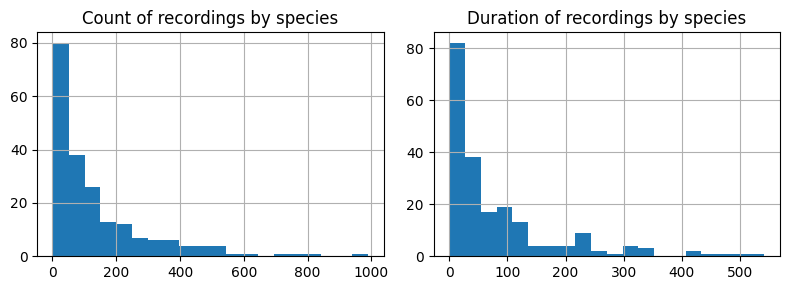

In [51]:
from matplotlib import pyplot as plt

pdf = by_species.toPandas()
# histogram of count and durations, log scale x axis
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
pdf["count"].hist(bins=20, ax=ax[0])
ax[0].set_title("Count of recordings by species")
pdf["duration_minutes"].hist(bins=20, ax=ax[1])
ax[1].set_title("Duration of recordings by species")
plt.tight_layout()
plt.show()

In [55]:
train_duration.describe().show()

25/03/23 15:00:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------------------+-----------+-----------------+
|summary|                path|          duration|    dataset|    primary_label|
+-------+--------------------+------------------+-----------+-----------------+
|  count|               28564|             28564|      28564|            28564|
|   mean|                NULL|35.352463163860115|       NULL|189219.3100436681|
| stddev|                NULL| 50.60564595255298|       NULL|308766.3189211122|
|    min|train_audio/11394...|        0.54459375|train_audio|          1139490|
|    max|train_audio/ywcpa...|          1774.392|train_audio|           ywcpar|
+-------+--------------------+------------------+-----------+-----------------+



In [62]:
display(train_duration.where("duration > (60*10)").count())
train_duration.orderBy("duration", ascending=False).show(20)
1774.392 / 60

20

+--------------------+-------------+-----------+-------------+
|                path|     duration|    dataset|primary_label|
+--------------------+-------------+-----------+-------------+
|train_audio/yerca...|     1774.392|train_audio|      yercac1|
|train_audio/compa...|   1509.98875|train_audio|       compau|
|train_audio/greeg...|     1255.056|train_audio|       greegr|
|train_audio/saffi...|     1076.904|train_audio|       saffin|
|train_audio/stbwo...|     1020.048|train_audio|      stbwoo2|
|train_audio/speow...|1010.36409375|train_audio|      speowl1|
|train_audio/colch...|      963.395|train_audio|      colcha1|
|train_audio/greki...|      946.128|train_audio|       grekis|
|train_audio/greki...|      935.064|train_audio|       grekis|
|train_audio/52884...| 896.57509375|train_audio|        52884|
|train_audio/bkcdo...|      783.984|train_audio|       bkcdon|
|train_audio/yerca...|  782.8636875|train_audio|      yercac1|
|train_audio/compa...|    711.11025|train_audio|       

29.5732